In [3]:
import re
import pandas as pd

# Gebsim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import warnings

# pyLDAvis
!pip install pyLDAvis
import pyLDAvis.gensim_models

# Coherence
from gensim.models.coherencemodel import CoherenceModel

warnings.filterwarnings("ignore")
from pprint import pprint

In [4]:
data = pd.read_csv('../data/reviews_clean.csv')

In [5]:
import nltk
stopwords = nltk.corpus.stopwords.words('english')
extra_words = ["hotel", "room", "nt", "great"]
stopwords.extend(extra_words)

In [6]:
for x in range(len(data)):
    data['Review_lemmatized'][x] = re.sub(r'[^\w\s]', '',  data['Review_lemmatized'][x])

    #data['Review_stopwords'][x] = data['Review_stopwords'][x].split()
    #data['Review_stopwords'][x] = [word for word in data['Review_stopwords'][x] if word not in stopwords]

In [7]:
# N-gram

nltk.download('averaged_perceptron_tagger')
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in  data['Review_lemmatized']])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)


# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stopwords or bigram[1] in stopwords:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    return True



# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]
bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]


# examples of bigrams
#bigrams[:10]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\larsb\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [8]:
# Concatenate n-grams
def replace_ngram(z):
    for gram in bigrams:
        z = z.replace(gram, '_'.join(gram.split()))
    return z


reviews_w_ngrams = data['Review_lemmatized'].copy()
reviews_w_ngrams = reviews_w_ngrams.map(lambda x: replace_ngram(x))
# tokenize reviews + remove stop words + remove names + remove words with less than 2 characters
reviews_w_ngrams = reviews_w_ngrams.map(lambda x: [word for word in x.split()\
                                                 if word not in stopwords\
                                                              and len(word) > 2])

reviews_w_ngrams.head()


0    [nice, expensive, parking, got, good, deal, st...
1    [nothing_special, charge, diamond, member, hil...
2    [nice, experience, monaco, seattle, good, leve...
3    [unique, stay, wonderful, time, monaco, locati...
4    [stay, stay, went, seahawk, game, awesome, dow...
Name: Review_lemmatized, dtype: object

In [9]:
# Filter for only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

final_reviews = reviews_w_ngrams.map(noun_only)

In [10]:
dictionary = corpora.Dictionary(final_reviews)

print('Number of unique words in initital documents:', len(dictionary))
# Filter out words that occur less than 5 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.5)
print('Number of unique words after removing rare and common words:', len(dictionary))

doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_reviews]


lda_model = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=4,
                                           random_state=100,
                                           chunksize=2000,
                                           passes=40,
                                           alpha='symmetric',
                                           eta= 0.1,
                                           iterations=100,
                                           #per_word_topics=True
                                                )

Number of unique words in initital documents: 48236
Number of unique words after removing rare and common words: 9542


In [11]:
# Print the keyword of topics
pprint(lda_model.print_topics())
doc_lda = lda_model[doc_term_matrix]





[(0,
  '0.014*"day" + 0.014*"night" + 0.011*"time" + 0.010*"got" + 0.009*"service" '
  '+ 0.008*"told" + 0.008*"desk" + 0.008*"problem" + 0.008*"bed" + '
  '0.008*"stay"'),
 (1,
  '0.028*"beach" + 0.026*"resort" + 0.024*"food" + 0.022*"pool" + 0.019*"day" '
  '+ 0.018*"time" + 0.013*"restaurant" + 0.010*"bar" + 0.009*"water" + '
  '0.009*"service"'),
 (2,
  '0.031*"location" + 0.028*"breakfast" + 0.019*"night" + 0.019*"stay" + '
  '0.017*"stayed" + 0.011*"city" + 0.011*"bathroom" + 0.010*"day" + '
  '0.010*"restaurant" + 0.009*"place"'),
 (3,
  '0.019*"stay" + 0.019*"location" + 0.017*"night" + 0.015*"stayed" + '
  '0.014*"service" + 0.014*"area" + 0.014*"place" + 0.013*"view" + '
  '0.011*"restaurant" + 0.010*"street"')]


In [12]:
# Lists documents most dominant topics and its percentage contribution in each document.

def format_topics_sentences(ldamodel=None, corpus=doc_term_matrix):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    sent_topics_df.Dominant_Topic = sent_topics_df.Dominant_Topic.astype('Int64')

    # Add original text to the end of the output
    contents = pd.Series(data['Review'])
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df



In [13]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=doc_term_matrix)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(5)



,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3,0.5472,"stay, location, night, stayed, service, area, ...",nice hotel expensive parking got good deal sta...
1,1,0,0.7331,"day, night, time, got, service, told, desk, pr...",ok nothing special charge diamond member hilto...
2,2,0,0.6953,"day, night, time, got, service, told, desk, pr...",nice rooms not 4* experience hotel monaco seat...
3,3,3,0.5871,"stay, location, night, stayed, service, area, ...","unique, great stay, wonderful time hotel monac..."
4,4,0,0.4773,"day, night, time, got, service, told, desk, pr...","great stay great stay, went seahawk game aweso..."


In [14]:
# Lists all topics and displays the most central tokens and representative sentence for each topic.

pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

# OKEY so almost all the top tokens are the same. So this sucks ass idk.

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9910,"day, night, time, got, service, told, desk, problem, bed, stay","thought luck reached hotel check straight away 9am opposed 2pm really really needed sleep, expec..."
1,1,0.9977,"beach, resort, food, pool, day, time, restaurant, bar, water, service","ca n't wait till year, 2nd 16th 2008we stayed lofts week 3 adults allow 2 adults suite rs.the se..."
2,2,0.9835,"location, breakfast, night, stay, stayed, city, bathroom, day, restaurant, place","great choice, thanks trip advisor, travelled london weekend friends wanted hotel close transport..."
3,3,0.9832,"stay, location, night, stayed, service, area, place, view, restaurant, street","happy stay chelsea motor inn just returned stay chelsea motor inn happy stay, love free parking ..."


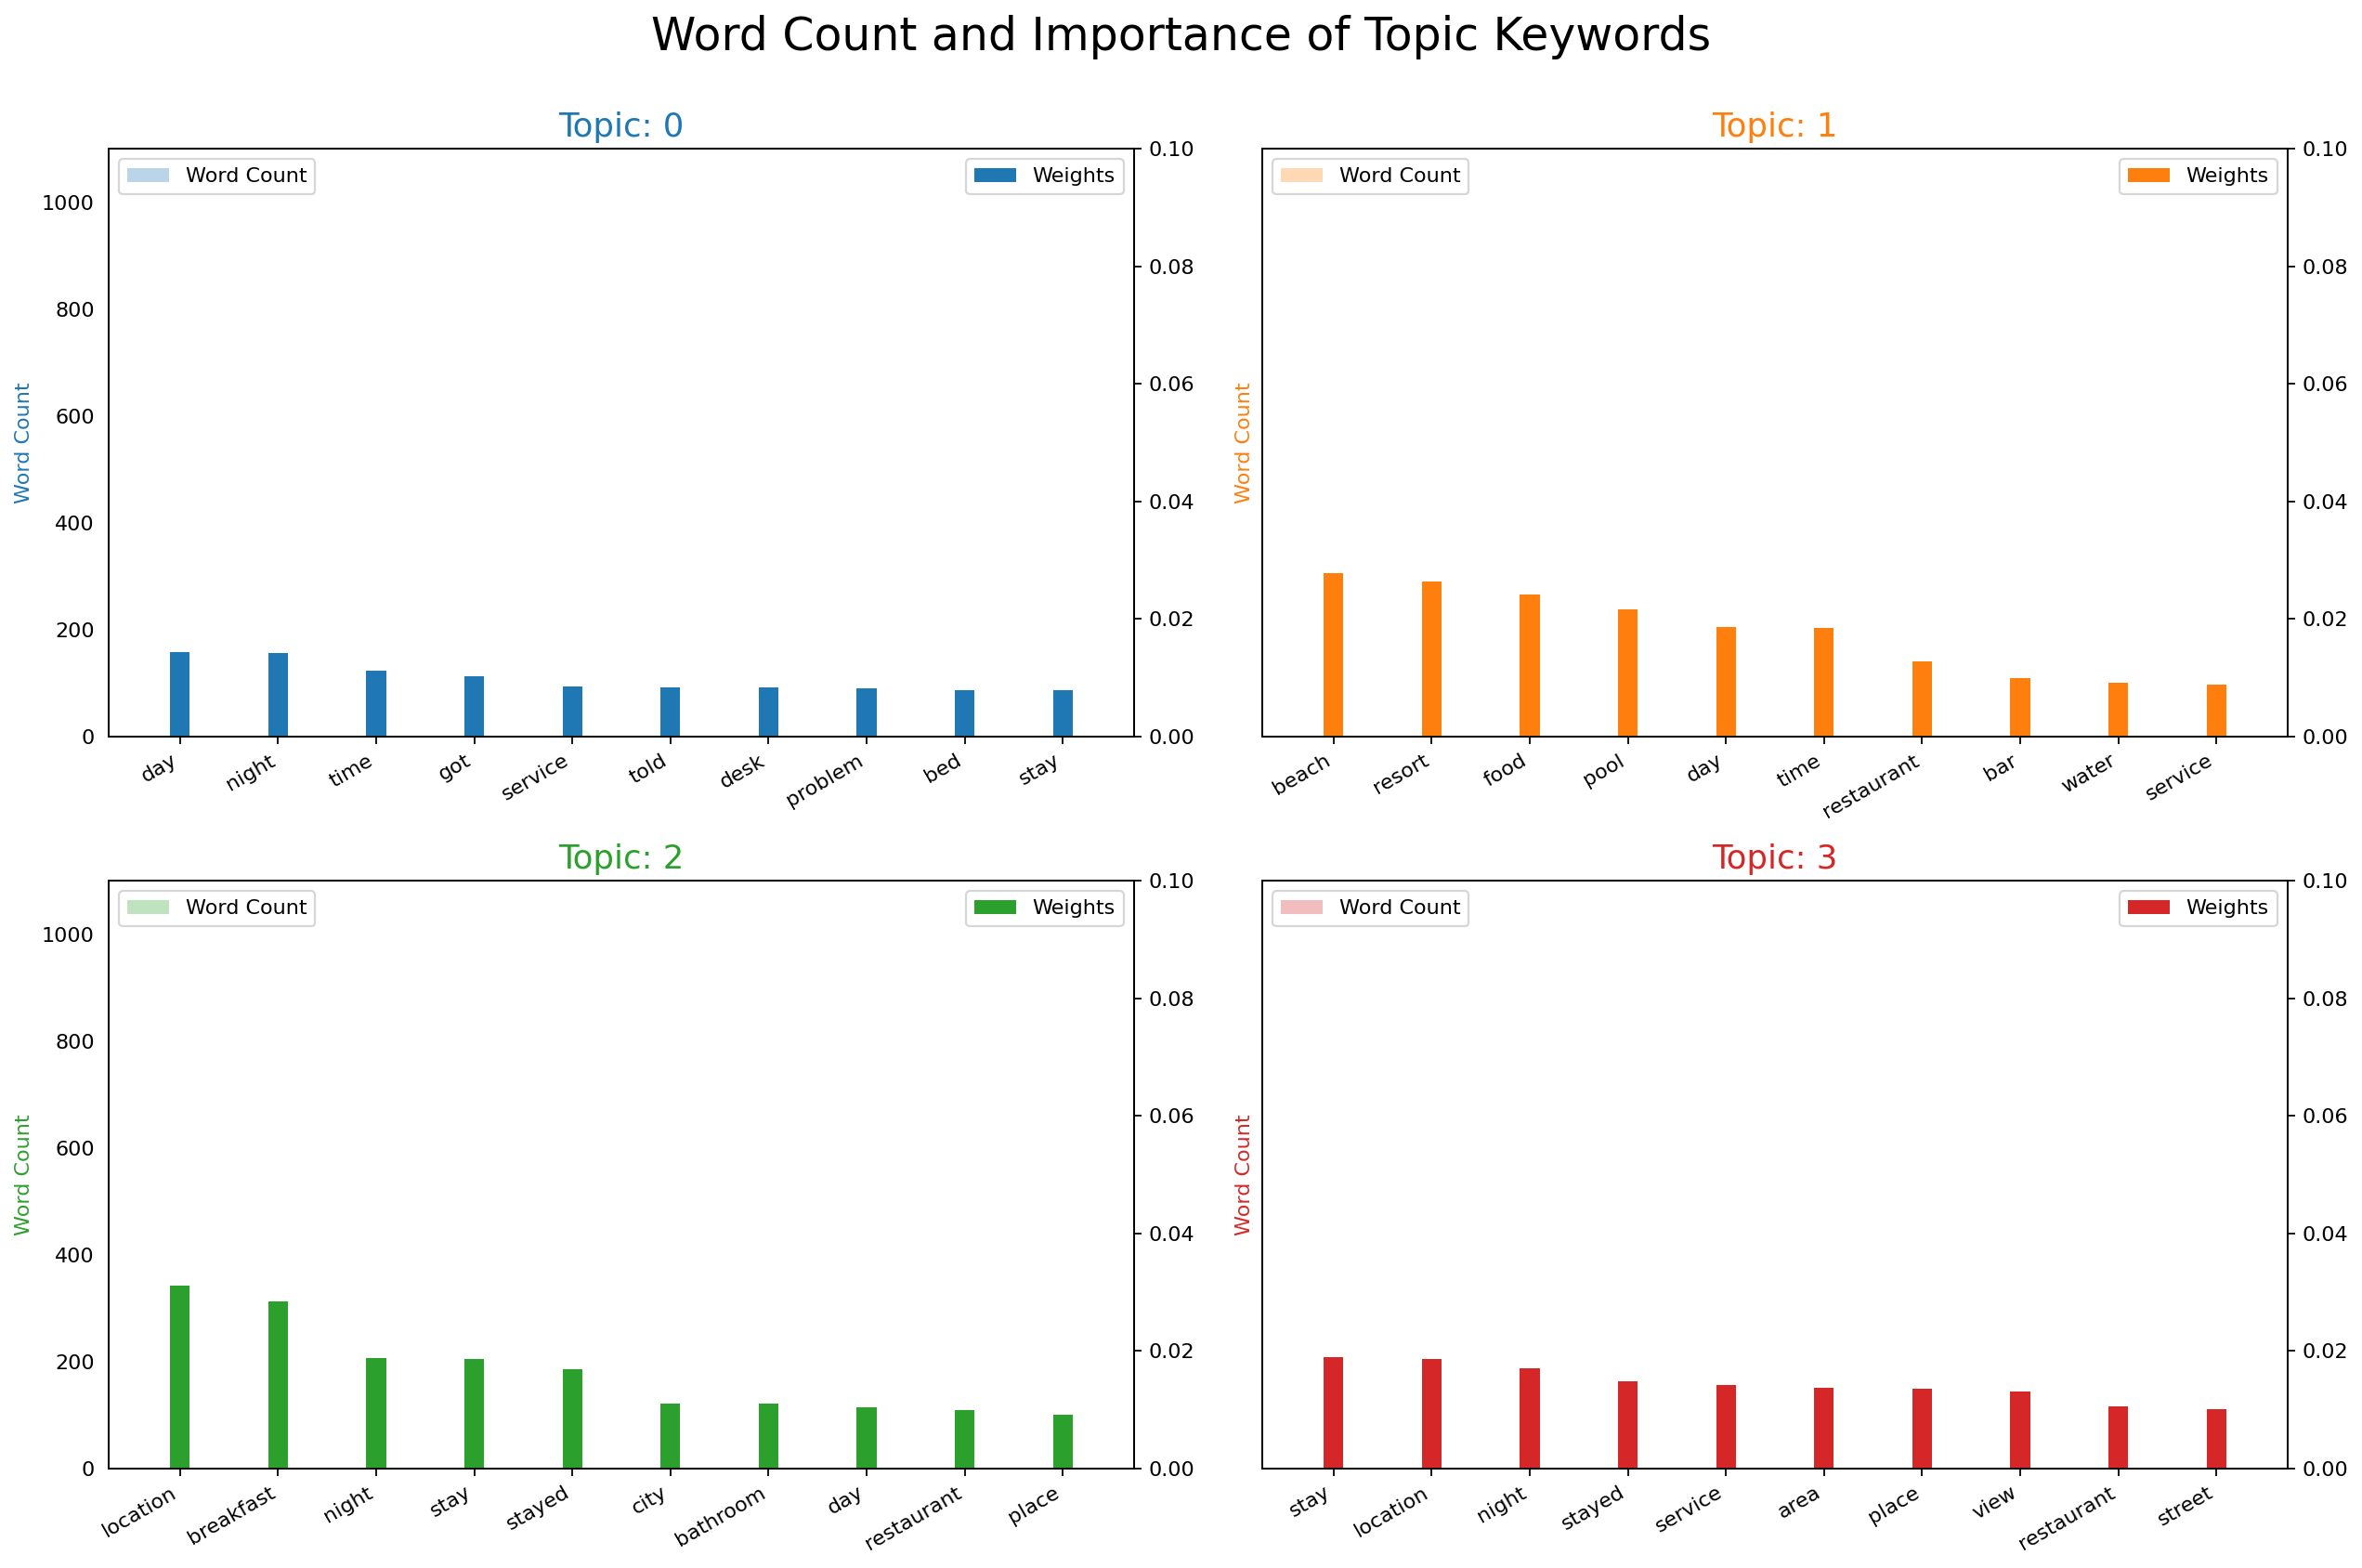

In [15]:
# Word Counts of Topic Keywords - Creating graphs to see how many words are in the different topics.

from collections import Counter
import matplotlib.colors as mcolors


topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data['Review'] for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i, weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3,
           label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id == i, :], color=cols[i], width=0.2,
                label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.1);
    ax.set_ylim(0, 1100)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
    ax.legend(loc='upper left');
    ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()



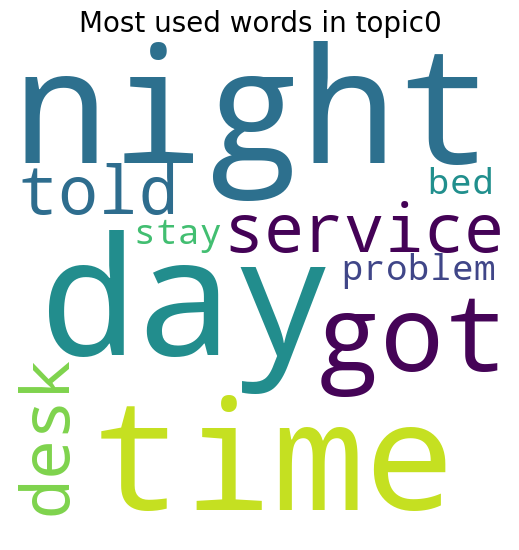

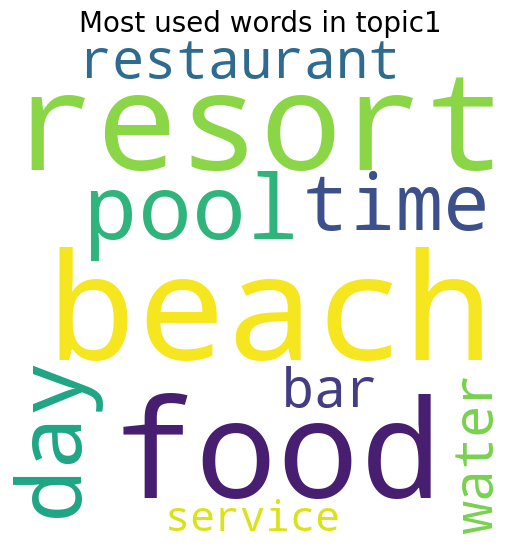

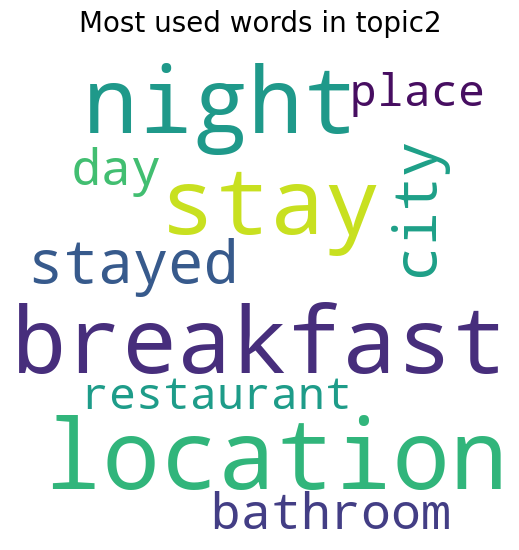

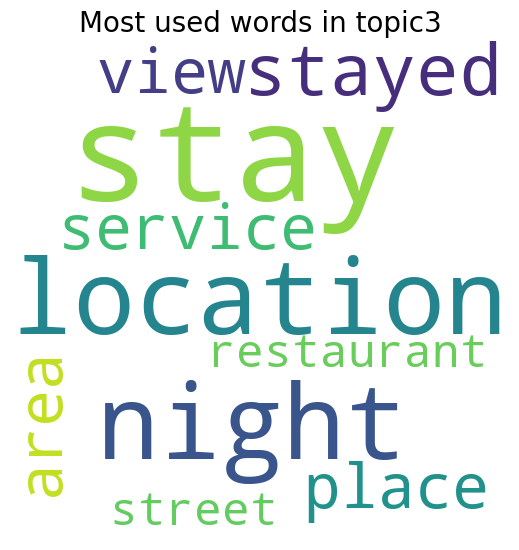

In [23]:
# Wordcloud of top N words in each topic

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

def create_WordCloud(data, title=None):
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color ='white',
                          min_font_size = 15
                         ).generate(" ".join(data))

    plt.figure(figsize = (5, 5), facecolor = None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title,fontsize=20)
    plt.show()


topics = lda_model.show_topics(formatted=False)
for x in range(len(topics)):
    create_WordCloud(dict(topics[x][1]), title="Most used words in topic" + str(x))

In [21]:
# U-mass and C_v cohesion..
cm = CoherenceModel(model=lda_model, corpus=doc_term_matrix, coherence='u_mass')
u_mass_score = cm.get_coherence()

#Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=final_reviews, dictionary=dictionary, coherence='c_v')
c_v_score = coherence_model_lda.get_coherence()

print('U_mass Score: ', u_mass_score,
      '\nC_v Score: ', c_v_score)

U_mass Score:  -1.4951542678037022 
C_v Score:  0.3808783010296138


In [22]:
# pyLDAvis visualization:

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.089935 -0.200141       1        1  30.179926
0     -0.193891  0.136827       2        1  27.515641
3      0.127230  0.047166       3        1  23.274378
2      0.156596  0.016149       4        1  19.030055, topic_info=           Term          Freq         Total Category  logprob  loglift
3304      beach   8796.000000   8796.000000  Default  30.0000  30.0000
3274     resort   8348.000000   8348.000000  Default  29.0000  29.0000
15     location  10739.000000  10739.000000  Default  28.0000  28.0000
50    breakfast   8615.000000   8615.000000  Default  27.0000  27.0000
734        pool   7492.000000   7492.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
48       booked   1148.306877   3616.492996   Topic4  -5.1561   0.5119
184       price   1231.978894   4457.487080   Topic4  -5.0858   0.3732
233        time   1417.726532  12707.786531   Topic4  -4.9454  -0.5340
130        trip    976.764470   4848.929427   Topic4  -5.3179   0.0569
188     service   1008.842384   9691.759324   Topic4  -5.2856  -0.6033

[307 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1183      4  1.000441  accomodation
236       1  1.000060      activity
134       2  0.044388       amenity
134       3  0.947364       amenity
134       4  0.008878       amenity
...     ...       ...           ...
297       4  0.045856          went
208       1  0.190238          work
208       2  0.680246          work
208       3  0.089354          work
208       4  0.040354          work

[461 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 3])